In [1]:
%load_ext autoreload
%autoreload 2

# Finding Similar Items: Textually Similar Documents
15.11.2021.<br>
[Ivan Klabucar, klabucar@kth.se] [Simon Langrieger, simlan@kth.se]<br>

In [2]:
from functions import *
import os
import pandas as pd
import time
from matplotlib import pyplot as plt

This assignment is about a method to compare bodies of texts and measure their similarities. For this we use shingling and Jaccard similarity.
To test the implementation and conduct some experiments we use a subset of 15 documents that appeared on Reuters newswire in 1987 (https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection). Some of the documents were edited by us to increase the similarity of certain documents.

Document 'MIX_OHIO_BROWN_CHEMLAWN.txt' is a mix of documents 'OHIO_MATTRESS.txt', 'BROWN_FORMAN.txt', and 'CHEMLAWN.txt'
Document 'MIX_CHEMLAWN_SHAMROCK.txt' is 'DIAMOND_SHAMROCK.txt' inserted into 'CHEMLAWN.txt'.

First we load the documents and save them in a dictionary, using their respective file names as key (while removing the .txt ending)

In [3]:
data = dict()
print('Documents in dataset:\n')
for i, filename in enumerate(os.listdir("dataset")):
    print(f'{i} {filename}')
    with open(os.path.join("dataset", filename), 'r') as f:
        data[filename[:-4]] = f.read()

Documents in dataset:

0 COMPUTER_TERMINAL_SYSTEMS.txt
1 OHIO_MATTRESS.txt
2 ARGENTINA_COULD_SUSPEND_DEBT PAYMENTS.txt
3 MIX_OHIO_BROWN_CHEMLAWN.txt
4 BRAZIL_ANTI_INFLATION_PLAN.txt
5 KEY_US_TAX_WRITERS_SEEK_ESTATE_TAX_CURBS.txt
6 TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND.txt
7 DEBT_DOWGRADED_BY_MOODYS.txt
8 CHEMLAWN.txt
9 US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS.txt
10 QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY.txt
11 DIAMOND_SHAMROCK.txt
12 MIX_CHEMLAWN_SHAMROCK.txt
13 BROWN_FORMAN.txt
14 TALKING_POINT_BANKAMERICA.txt


Then we shingle all documents using a shingle length k of 9. In the shingle function we prepare each document by removing all punctuations and transforming everything to lower case text.
We then take substrings of length k and hash them using the adler32 hash function from the library zlib which returns a 4-byte hash of any string.
The hashed shingles of each document are saved in a set to remove duplicate shingles and then stored in another dictionary.

To speed up comparisons we use a technique called min-hashing where we create signatures for documents of variable length n.
For this we create n different random hash functions of the form (ax + b) % c with random a and b and a fixed c. Using these signatures only allows us to calculate an estimate of the jaccard similarity however. Hence we're trading performance with accuracy

We apply this min-hashing technique with n=200 and store the signatures in another dictionary.

In [4]:
#Shingling the dataset
list_of_data = [c for c in data]
shingled_data = dict()
THRES = 0.07
for c in data:
    shingled_data[c] = shingle(data[c], k=9)
    
#Creating signatures for the dataset
min_hasher = MinHash(n=200)
signed_data = dict()
for c in data:
    signed_data[c] = min_hasher.create_signature(shingled_data[c])

We implemented the "heavy worker methods" in an extra python file but create here some shortcuts which abstract the methods to make it more user-friendly for us to work with.

In [5]:
#Code for searching for similar pairs
def jaccard(c1, c2):
    return compareSets(shingled_data[c1], shingled_data[c2])

def jaccard_estimate(c1, c2, signatures=signed_data):
    return compare_signatures(signatures[c1], signatures[c2])

# here we create a table with all documents as rows and columns and their 
# respective value of similarity measured with the given method
def calculate_similarity_of_all_pairs(method, documents=list_of_data):
    result = pd.DataFrame(columns=documents)
    for row in documents:
        result[row] = [method(row, col) for col in documents]
    return result

In [6]:
# returns for a given similarity table all pairs which are above a given threshold
def find_pairs_above_threshold(df, threshold, documents=list_of_data):
    checked = set()
    result = set()
    for col in df:
        checked.add(col)
        for i, sim in enumerate(df[col]):
            curr = documents[i]
            # similarity is symmetrical, hence we only check about half of the table
            if curr in checked: continue
            if sim > threshold: result.add((col, curr))
    return result
            

# Part 1 - Study in true/false positives

First we add some functions to visualize our results. 
- First a method to plot the similarity in a confusion-matrix-like fashion. The brighter a cell is, the more similar two documents are
- And second a simple formatted print statement to output the similar pairs

In [15]:
def plot_matrix(mat):
    plt.figure(dpi=200)
    plt.matshow(mat)
    plt.yticks(range(len(list_of_data)), list_of_data, rotation="horizontal")
    plt.xticks(range(len(list_of_data)), list_of_data, rotation="vertical")
    plt.colorbar()
    plt.show()

def print_pairs(pairs):
    print("\n".join([f"{r[0]} - {r[1]}" for r in pairs]))
    

We then calculated the exact jaccard similarity, plotted the results with the previous function...

<Figure size 1200x800 with 0 Axes>

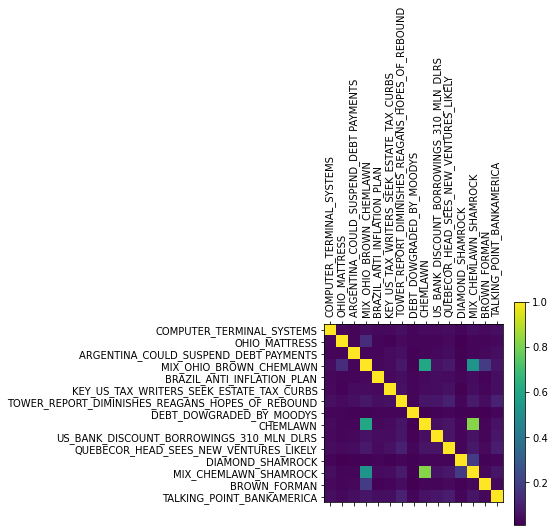

QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY - MIX_CHEMLAWN_SHAMROCK
OHIO_MATTRESS - MIX_OHIO_BROWN_CHEMLAWN
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS
MIX_OHIO_BROWN_CHEMLAWN - TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY
MIX_OHIO_BROWN_CHEMLAWN - BROWN_FORMAN
CHEMLAWN - MIX_CHEMLAWN_SHAMROCK
QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY - TALKING_POINT_BANKAMERICA
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - MIX_CHEMLAWN_SHAMROCK
MIX_OHIO_BROWN_CHEMLAWN - CHEMLAWN
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - TALKING_POINT_BANKAMERICA
MIX_OHIO_BROWN_CHEMLAWN - QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY
US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS - TALKING_POINT_BANKAMERICA
MIX_OHIO_BROWN_CHEMLAWN - MIX_CHEMLAWN_SHAMROCK
DIAMOND_SHAMROCK - MIX_CHEMLAWN_SHAMROCK


In [16]:
#Calculating the Jaccard similarity for every pair of documents
jaccard_sim_map = calculate_similarity_of_all_pairs(jaccard)

plot_matrix(jaccard_sim_map)

gt_result = find_pairs_above_threshold(jaccard_sim_map, THRES)
print_pairs(gt_result)
    

... and did the same with the estimated jaccard similarity ...

<Figure size 1200x800 with 0 Axes>

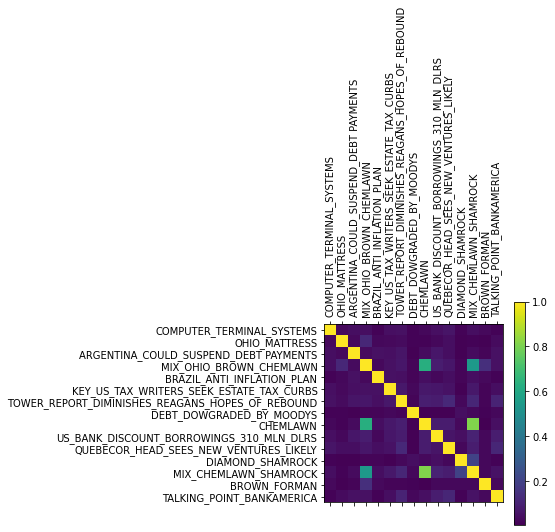

QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY - MIX_CHEMLAWN_SHAMROCK
OHIO_MATTRESS - MIX_OHIO_BROWN_CHEMLAWN
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY
MIX_OHIO_BROWN_CHEMLAWN - BROWN_FORMAN
CHEMLAWN - MIX_CHEMLAWN_SHAMROCK
QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY - TALKING_POINT_BANKAMERICA
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - CHEMLAWN
MIX_OHIO_BROWN_CHEMLAWN - CHEMLAWN
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - MIX_CHEMLAWN_SHAMROCK
US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS - MIX_CHEMLAWN_SHAMROCK
US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS - TALKING_POINT_BANKAMERICA
TOWER_REPORT_DIMINISHES_REAGANS_HOPES_OF_REBOUND - TALKING_POINT_BANKAMERICA
MIX_OHIO_BROWN_CHEMLAWN - US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS
CHEMLAWN - QUEBECOR_HEAD_SEES_NEW_VENTURES_LIKELY
CHEMLAWN - US_BANK_DISCOUNT_BORROWINGS_310_MLN_DLRS
MIX_OHIO_BROWN_CHEMLAWN - MI

In [17]:
#Estimating the Jaccard similarity for every pair of documents
jaccard_sim_estim_map = calculate_similarity_of_all_pairs(jaccard_estimate)
plot_matrix(jaccard_sim_estim_map)

est_result = find_pairs_above_threshold(jaccard_sim_estim_map, THRES)
print_pairs(est_result)

... and looked at true/false positives/negatives.

In [18]:
print('Results of estimate')
# counting the pairs which are in both sets
acum = 0
for p in est_result:
    if p in gt_result or (p[1], p[0]) in gt_result: 
        acum += 1
print(f'Length of estimated result: {len(est_result)}')
print(f'Length of real result: {len(gt_result)}')
print(f'Found {acum}/{len(gt_result)}')  # From these two lines we get information about true/false positive rate

Results of estimate
Length of estimated result: 18
Length of real result: 15
Found 13/15


When there are a lot of documents and we want to calculate the pairwise similarities, the number of calculations grows quadratic with the number of documents. Therefore, we preselect candidates to calculate the estimated jaccard similarity to reduce the number of needed calculations. However, we again have to trade performance with accuracy.

For this we use LSH, where the signature of a document is divided into bands which are then hashed. Finally we calculate the (estimated) jaccard similarity only for those pairs of documents for which at least one of their respective bands got hashed into the same bucket. 
The implementation for this can again be found in functions.py

Finally we conduct the same experiment as before but of course don't plot a matrix since the whole point is not to compare every document with every other document.

In [19]:
# Locally sensitive hashing
lsh = LSH(signatures=signed_data, num_of_bands=50, threshold=THRES)
lsh_result = lsh.get_candidates_above_threshold(jaccard_estimate)


print('Results of LSH')                                                         # b = num_of_bands
for p in lsh_result:                                                            # t = threshold, r = rows within a band
    print(f'{jaccard_sim_estim_map.loc[list_of_data.index(p[0]), p[1]]} {p}')   # explain results with 1 - (1 - t^r)^b
print()
    
acum = 0
for p in lsh_result:
    if p in gt_result or (p[1], p[0]) in gt_result: acum += 1
print(f'Length of estimated result: {len(lsh_result)}')
print(f'Length of real result: {len(gt_result)}')
print(f'Found {acum}/{len(gt_result)}')

Results of LSH
0.81 ('CHEMLAWN', 'MIX_CHEMLAWN_SHAMROCK')
0.63 ('CHEMLAWN', 'MIX_OHIO_BROWN_CHEMLAWN')
0.545 ('MIX_CHEMLAWN_SHAMROCK', 'MIX_OHIO_BROWN_CHEMLAWN')

Length of estimated result: 3
Length of real result: 15
Found 3/15


The relatively poor result can be explained with the formula:<br>
t -> similarity<br>
b -> number of bands<br>
r -> number of rows within a band<br>
X = Two documents with similarity t sharing at least one bucket<br>
$Pr[X] = 1 - ( 1 - t^r )^b$ <br>

Calculating the above formula for our case:<br>
t = 0.07<br>
b = 50<br>
r = 4<br>
$Pr[X] = 1.199 \cdot 10^{-3}$ <br>

That means that it is simply very unlikely that LSH will be able to recognize documents with such low similarity as candidates.<br>

The story changes when we plug into a higher similarity into the formula, all other thing being equal and t = 0.5:
$Pr[X] = 0.96$<br>

Meaning that LSH is very likely to 'catch' documents with higher similarities. This is exactly what happened in our case. The LSH method succeeded in finding documents with high similarities, but failed to do so with documents of lower similarities even though their similarity exceeded the defined threshold.<br>

At the end of part 1 we implemented and explored the full pipeline described in the lecture: shingling -> minhashing -> lsh.

# Part 2 - Study in scalability

We will try to get a sense of the speed of execution by applying the above described algorithms to a dataset of increasing size. We will construct the larger data sets by repeatedly copying the original back into the larger one. The larger data set will contain duplicates

First we defined an easy-to-use function to increase the dataset size

In [12]:
def dict_extend(d_to_extend, with_d, time):
    for k in with_d:
        d_to_extend[k + f'-{time}'] = with_d[k]

We then steadily increase the dataset size and look for similar documents for the respective dataset and take the time for:
1. the jaccard-estimate using only the signatures
2. the jaccard-estimate but preselected using lsh

In [13]:
signature_time = []
lsh_time = []

NUM_OF_EXPERIMENTS = 30
larger_data = dict()
for i in range(NUM_OF_EXPERIMENTS):
    # increase of dataset size
    dict_extend(d_to_extend=larger_data, with_d=signed_data, time=i)
    doc_list = [k for k in larger_data]
    
    # finding similar pairs using the jaccard_estimate
    start = time.time()
    res = calculate_similarity_of_all_pairs(                                  \
                lambda a,b: jaccard_estimate(a, b, signatures=larger_data),   \
                documents=doc_list                                            \
    )
    final = find_pairs_above_threshold(res, THRES, documents=doc_list)
    end = time.time()
    signature_time.append(end - start)
    
    # finding similar pairs but with lsh pre-selection
    start = time.time()
    lsh = LSH(signatures=larger_data, num_of_bands=50, threshold=THRES)
    lsh_result = lsh.get_candidates_above_threshold(jaccard_estimate, data_with_duplicates=True)
    end = time.time()
    lsh_time.append(end - start)

Finally we plot the run-times:

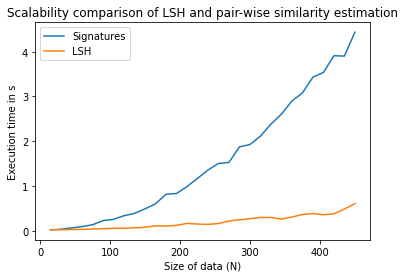

In [14]:
x = [i*15 for i in range(1,NUM_OF_EXPERIMENTS+1)]
plt.figure(1)
plt.plot(x, signature_time, label='Signatures')
plt.plot(x, lsh_time, label='LSH')
plt.ylabel('Execution time in s')
plt.xlabel('Size of data (N)')
plt.legend()
plt.title('Scalability comparison of LSH and pair-wise similarity estimation')
plt.show()

We clearly see the speed-up with increasing dataset size, when using lsh. We also can see the quadratic increase in run-time when we do not use the lsh preselection while lsh's run-time appears to increase linearly.